<a href="https://colab.research.google.com/github/Jeditem/VKCup_2020/blob/master/VKCup_2_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import itertools
import numpy as np
import pandas as pd
import pandas_profiling as pd_prof
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import lognorm
%matplotlib inline


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
users_df = pd.read_csv(r'/content/gdrive/My Drive/VKCup/users.tsv', sep='\t')
history_df = pd.read_csv(r'/content/gdrive/My Drive/VKCup/history.tsv', sep='\t')
validate_df = pd.read_csv(r'/content/gdrive/My Drive/VKCup/validate.tsv', sep='\t')
answers_df = pd.read_csv(r'/content/gdrive/My Drive/VKCup/validate_answers.tsv', sep='\t')

In [0]:
# Сначала сконвертим колонки с площадками и юзерами в листы и возьмем их размеры
validate_df['user_ids'] = validate_df['user_ids'].astype(str).str.split(',')
validate_df['audience_size'] = validate_df['user_ids'].str.len()
validate_df['publishers'] = validate_df['publishers'].astype(str).str.split(',')
validate_df['publishers_amount'] = validate_df['publishers'].str.len()
# Здесь де вычислим продолжительность рекламы
validate_df['ads_duration'] = validate_df['hour_end'] - validate_df['hour_start']

validate_df = validate_df.join(answers_df)

In [0]:
validate_df

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,publishers_amount,ads_duration,at_least_one,at_least_two,at_least_three
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,95,0.0430,0.0152,0.0073
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",2,6,0.0130,0.0000,0.0000
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",6,20,0.0878,0.0135,0.0000
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",2,82,0.2295,0.1295,0.0727
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",4,238,0.3963,0.2785,0.2270
...,...,...,...,...,...,...,...,...,...,...,...
1003,127.0,1095,1154,"[2, 7, 12, 15, 16]",368,"[38, 50, 143, 237, 456, 649, 653, 698, 881, 89...",5,59,0.0679,0.0408,0.0190
1004,90.0,1052,1056,"[2, 21]",484,"[1, 4, 61, 212, 230, 348, 356, 372, 429, 431, ...",2,4,0.0165,0.0000,0.0000
1005,122.0,1058,1063,"[2, 5]",704,"[1, 23, 29, 104, 136, 176, 201, 206, 250, 269,...",2,5,0.0071,0.0000,0.0000
1006,138.0,932,1169,"[1, 2, 7]",1210,"[67, 73, 80, 146, 182, 202, 212, 254, 307, 377...",3,237,0.3669,0.2628,0.2066


In [0]:
sns.jointplot(x='audience_size', y='at_least_one', data=validate_df)
# sns.jointplot(x='cpm', y='at_least_two', data=validate_df)
# sns.jointplot(x='cpm', y='at_least_three', data=validate_df)

In [0]:
users_lists = validate_df['user_ids'].values
users_lists = (list(itertools.chain.from_iterable(users_lists)))
users_counter = Counter(users_lists)

In [0]:
validate_df.hour_start.min()

747

In [0]:
history_df

,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148
...,...,...,...,...
1147852,382,45.00,1,7871
1147853,360,33.35,1,7992
1147854,381,205.00,1,21516
1147855,383,37.50,1,8224


In [0]:
# сначала почистим CPM от ада в 2000 тысяч
history_df_mod = history_df[(history_df.cpm <= 1000)]
users_costs = history_df_mod.groupby('user_id')['cpm'].mean()
users_df = users_df.join(users_costs).fillna(0.0)

In [0]:
users_df.head()

,user_id,sex,age,city_id,cpm
0,0,2,19,0,805.650000
1,1,1,0,1,111.525679
2,2,2,24,2,0.000000
3,3,1,20,3,370.880000
4,4,2,29,4,44.627955


In [0]:
# теперь вычислим для каждой ставки, среднюю стоимость товарищей, на которых она целится, и разницу
def calculate_mean_cpm_by_users (users_list):
    total_cpm = []
    for user in users_list:
        curr_user_cost = users_df.iloc[[int(user)]]['cpm']
        total_cpm.append(curr_user_cost.values[0])
    return np.mean(total_cpm)


In [0]:
%%time
validate_test = validate_df.copy()
validate_test['mean_cost'] = validate_test.apply(lambda row: calculate_mean_cpm_by_users(row['user_ids']), axis=1)


CPU times: user 8min 8s, sys: 1.29 s, total: 8min 9s
Wall time: 8min 7s


In [0]:
validate_test['discrepancy'] = validate_test['mean_cost'] - validate_test['cpm']

In [0]:
validate_test.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,publishers_amount,ads_duration,at_least_one,at_least_two,at_least_three,mean_cost,discrepancy
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,95,0.0430,0.0152,0.0073,201.954843,-18.045157
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",2,6,0.0130,0.0000,0.0000,160.744132,-151.255868
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",6,20,0.0878,0.0135,0.0000,184.204108,114.204108
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",2,82,0.2295,0.1295,0.0727,204.438568,-35.561432
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",4,238,0.3963,0.2785,0.2270,219.125446,-42.874554


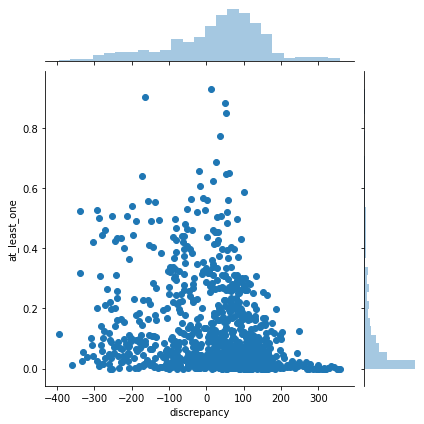

In [0]:
sns.jointplot(x='discrepancy', y='at_least_one', data=validate_test)
# кажется, если глянуть вероятнось по этому распределению, можно получить приятный результат
# UPD практика показала, что можно даже не считать вероятность, модельке хватает разницы

In [0]:
# можно еще отношение глянуть
validate_test['relative_dif'] = validate_test['mean_cost'].div(validate_test['cpm'])

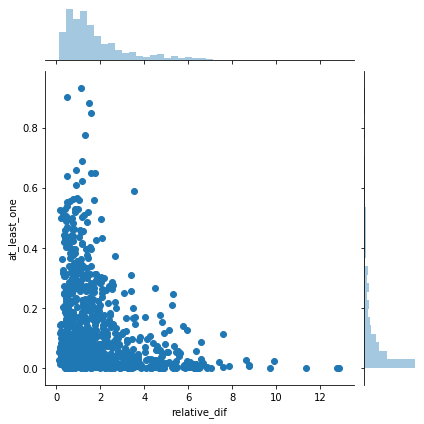

In [0]:
sns.jointplot(x='relative_dif', y='at_least_one', data=validate_test)
# ну, с ним тоже можно потестить